# 0. SETUP

In [178]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [179]:
!pip install --quiet tensorflow_io

import tensorflow as tf
import tensorflow_io as tfio

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import models, layers, optimizers, applications, callbacks

In [180]:
! pip install --quiet geopandas

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import datetime

import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

from ipywidgets import interact
from IPython.display import Audio

In [181]:
### --- Data --- ###
ROOT_PATH = 'drive/MyDrive/Birds/'
DIRECTORY_TRAIN = ROOT_PATH + 'data_30s/train/'
DIRECTORY_TEST = ROOT_PATH + 'data_30s/test/'
DIRECTORY_PRED = ROOT_PATH + 'results/'

### --- Spectrograms --- ###
TARGET_SAMPLE_RATE = 16000
TARGET_SPLIT_DURATION_SEC = 10
NFFT=400
WINDOW=400
STRIDE=100

### --- Dataset --- ###
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
NUM_TARGETS = 50
NUM_RECORDS = 1650
RECORDS_PER_SPECIES = 33
BUFFER_SIZE = 10
SPECTROGRAM_TYPE = 'mel'

### --- Predictions --- ###
MODEL_PATH = ROOT_PATH + 'models/model_densenet169_v4'

In [182]:
y_train = pd.read_csv(DIRECTORY_TRAIN + 'y_train.csv')
y_test = pd.read_csv(DIRECTORY_TEST + 'y_test.csv')
y_pred = pd.read_csv(DIRECTORY_PRED + 'y_pred.csv')

metadata = pd.read_csv(ROOT_PATH + 'metadata.csv')
metadata_train = pd.read_csv(ROOT_PATH + 'metadata_train.csv')
metatdata_test = pd.read_csv(ROOT_PATH + 'metadata_test.csv')
matching_table = pd.read_csv(ROOT_PATH + 'matching_table.csv')

species_list = list(matching_table['Species'])

# 1. PRESENTATION

## 1.1 Do you know this bird ? 🐥

## 1.2 Dataset 🦜

### 1.2.1 Audio files' lengths

#### i. Code

In [183]:
def get_clean_path(mp3_path):
    path = mp3_path.split("mp3//")[-1]
    ogg_path = path.split(".mp3")[0] + '_tens.ogg'
    return ogg_path

In [184]:
def get_names_df(metadata):
    names_df = metadata.copy()[['Recording_ID', 'Species', 'Path', 'English_name']]
    names_df['Path'] = names_df['Path'].apply(get_clean_path)
    return names_df

In [185]:
def to_seconds(string):
    t = datetime.datetime.strptime(string, "%M:%S")
    return t.minute * 60 + t.second

In [186]:
def get_durations_df(metadata):
    durations_df = metadata.copy()[['Recording_ID', 'Species', 'Path', 'English_name', 'Length']]
    durations_df['Path'] = durations_df['Path'].apply(get_clean_path)
    durations_df['Length'] = durations_df['Length'].apply(to_seconds)
    return durations_df

In [187]:
def plot_length_distribution(metadata):
    durations_df = get_durations_df(metadata)
    plt.figure(figsize=(15, 8))
    sns.histplot(data=durations_df, x='Length', hue='Species', multiple='stack')
    plt.xlabel("Record's length (seconds)")
    plt.title("Distribution of records' lengths", fontsize=20)
    ax = plt.gca()
    ax.get_legend().remove();

#### ii. Graph

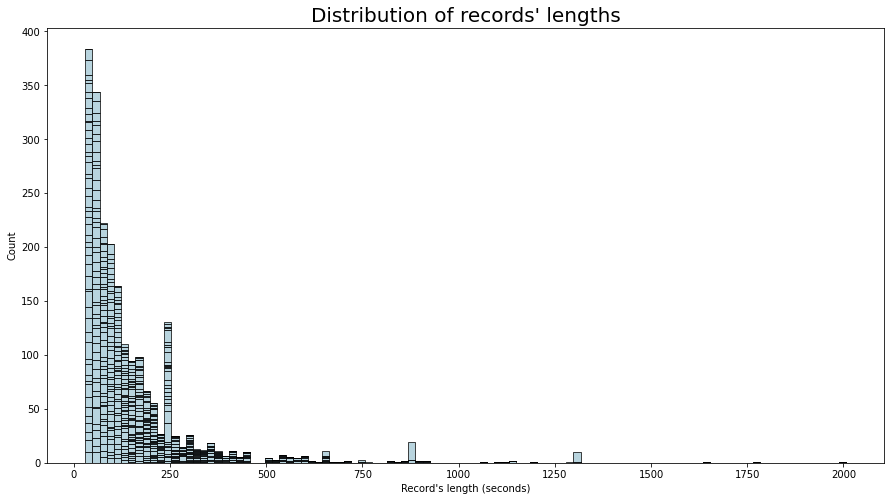

In [188]:
plot_length_distribution(metadata)

### 1.2.2 Locations

#### i. Code

In [189]:
def get_locations_df(metadata):
    locations_df = metadata.copy()[['Recording_ID', 'Species', 'Path', 'English_name', 'Country', 'Latitude', 'Longitude']]
    locations_df['Path'] = locations_df['Path'].apply(get_clean_path)
    return locations_df

In [190]:
def print_species(species_list, metadata):

    # Get locations df
    locations_df = get_locations_df(metadata)

    # Get max longitude - latitude
    lat_lon = {'latitude': (locations_df['Latitude'].min() - 5, locations_df['Latitude'].max() + 5),
               'longitude': (locations_df['Longitude'].min() - 5, locations_df['Longitude'].max() + 5)}

    # Get map
    world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Create geometry
    geometry = [Point(xy) for xy in zip(locations_df["Longitude"], locations_df["Latitude"])]

    # Geo Dataframe
    geo_df = gpd.GeoDataFrame(locations_df, geometry=geometry)

    # Plot
    fig, ax = plt.subplots(figsize = (15, 10))
    world_map.plot(ax=ax, alpha=0.4, color="#d9d9d9")

    palette = iter(sns.color_palette(palette="viridis", n_colors=len(species_list)))

    for specie in species_list:
        geo_df[geo_df['Species'] == specie].plot(ax=ax,color=next(palette), label=specie, alpha=0.6)

    ax.set_xlim(lat_lon['longitude'])
    ax.set_ylim(lat_lon['latitude'])

    plt.axis()
    plt.xticks([], [])
    plt.yticks([], [])

    ax.spines['left'].set_color('grey')
    ax.spines['top'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.spines['right'].set_color('grey')
    
    plt.title("Records' locations", fontsize=45, color='#666666');

#### ii. Map

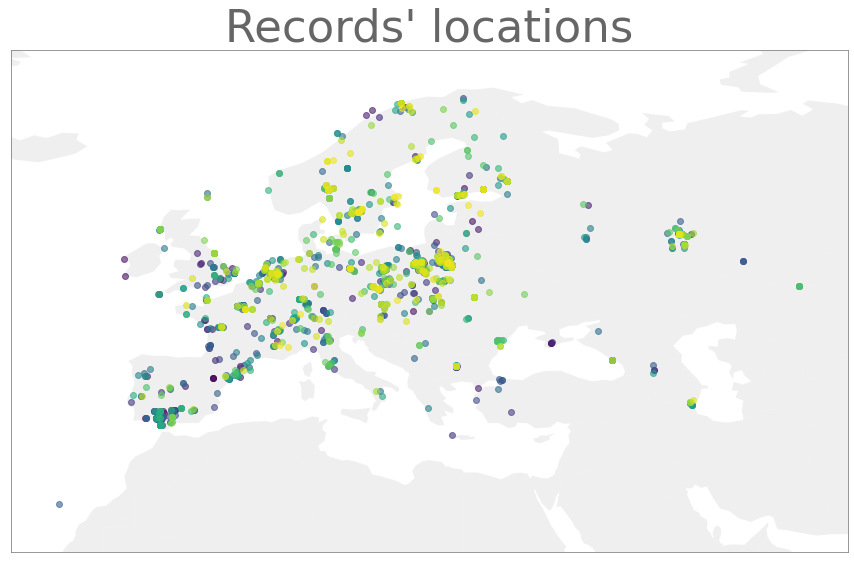

In [191]:
print_species(species_list, metadata)

### 1.2.3 Times of recording

#### i. Code

In [192]:
def clean_date(date):
    new_date = date.replace('-00', '-01')
    return new_date

In [193]:
def clean_time(time):
    new_time = time.replace('--', ':').replace('-', ':')
    return new_time

In [194]:
def get_times_df(metadata):
    
    # getting interesting features
    times_df = metadata.copy()[['Recording_ID', 'Species', 'Path', 'Time', 'Date']]
    times_df['Path'] = times_df['Path'].apply(get_clean_path)
    
    # cleaning date and getting month
    times_df['Date'] = times_df['Date'].apply(clean_date)
    times_df['Date'] = pd.to_datetime(times_df['Date'], errors='coerce').dt.date
    times_df['Month'] = times_df['Date'].apply(lambda x: x.month)
    
    # cleaning time
    times_df['Time'] = times_df['Time'].apply(clean_time)
    times_df['Time'] = pd.to_datetime(times_df['Time'], errors='coerce').dt.time
    
    return times_df

In [195]:
def plot_times_distribution(metadata):
    times_df = get_times_df(metadata)
    plt.figure(figsize=(15, 8))
    sns.histplot(data=times_df, x='Month', hue='Species', multiple='stack', discrete=True)
    ax=plt.gca()
    plt.xlabel("Month of recording")
    plt.title("Distribution of months of recording", fontsize=20)
    ax.get_legend().remove();

#### ii. Graph

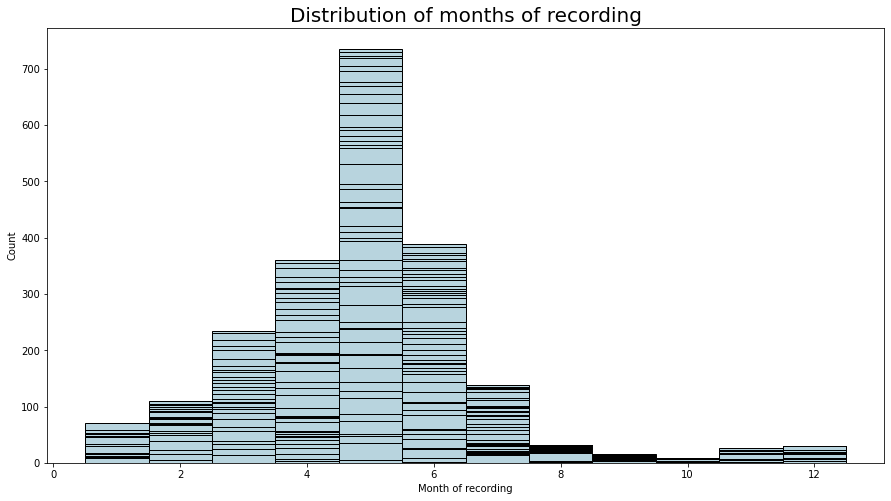

In [196]:
plot_times_distribution(metadata)

### 1.2.4 Other species

#### i. Code

In [197]:
other_species_col = ['Other_species']
for i in range(1,31):
    other_species_col.append('Other_species' + str(i))

In [198]:
def get_all_species(row):
    species = [row[col] for col in other_species_col]
    
    unique_species = []
    
    for specie in species :
        if specie not in unique_species:
            if specie != row['Species']:
                unique_species.append(specie)
    
    unique_species.remove('')
    
    return unique_species

In [199]:
def get_target_species(species_list):
    
    return [specie for specie in species_list if specie in species_list]

In [200]:
def get_other_species_df(metadata):
    
    # getting interesting features
    other_species_df = metadata.copy()[['Recording_ID', 'Species', 'Path'] + other_species_col]
    other_species_df['Path'] = other_species_df['Path'].apply(get_clean_path)
    other_species_df.replace(np.nan, '', inplace=True)
    
    # getting list of all species
    other_species_df['all_other_species'] = other_species_df.apply(get_all_species, axis=1)

    # getting list of species that are known in 'Species' column
    other_species_df['target_other_species'] = other_species_df['all_other_species'].apply(get_target_species)
    
    # droping 'other_speciesx' columns
    other_species_df.drop(columns=other_species_col, inplace=True)
    
    # getting other species counts
    other_species_df['all_other_species_num'] = other_species_df['all_other_species'].apply(lambda x: len(x))
    other_species_df['target_other_species_num'] = other_species_df['target_other_species'].apply(lambda x: len(x))
    
    # getting jittered counts (for plotting)
    
    # x = np.random.normal(0, .3, size=other_species_df.shape[0])
    # y = np.random.normal(0, .3, size=other_species_df.shape[0])
    
    # other_species_df['jitt_all_other_species_num'] = other_species_df['all_other_species_num'] + y
    # other_species_df['jitt_target_other_species_num'] = other_species_df['target_other_species_num'] + x
    
    return other_species_df

In [201]:
def plot_other_species(metadata):
    other_species_df = get_other_species_df(metadata)

    plt.figure(figsize=(15, 8))

    sns.histplot(data=other_species_df, 
                 x='target_other_species_num', 
                 hue='Species',
                 palette='viridis', 
                 edgecolor="white",
                 multiple='stack', 
                 discrete=True)
    
    plt.xlabel('Number of other species', fontsize=25, color='#666666')
    plt.ylabel('Number of records', fontsize=25, color='#666666')
    plt.title('Number of species per record', fontsize=40, color='#666666')

    ax = plt.gca()

    ax.spines['left'].set_color('grey')
    ax.spines['top'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.spines['right'].set_color('grey')

    ax.tick_params(colors='#666666', labelsize=20)

    
    ax.get_legend().remove();

#### ii. Graph

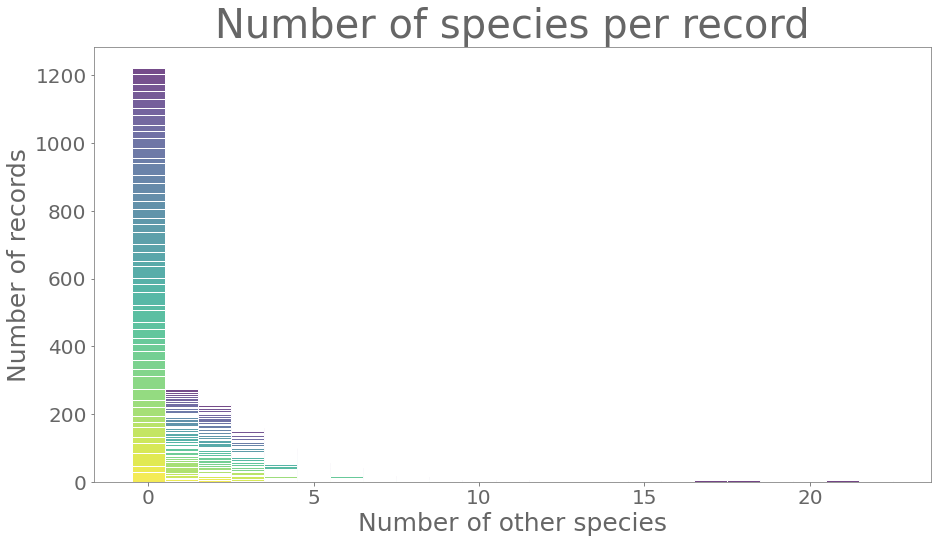

In [202]:
plot_other_species(metadata)

## 1.3 Preprocessing audio files 🎶

#### i. Code

In [ ]:
def generate_tensor(file_path, label, 
                    split=True, output_rate=TARGET_SAMPLE_RATE):
    '''
    Objective : Generate tensor from file path and return all steps
    Input : file_path , label = integer between 0 and 49
    Output : tf.Tensor shape(x,), label, input_rate, output_rate
    '''
    
    # 1 - Convert audio file to AudioTensor
    audio_tensor = tfio.audio.AudioIOTensor(file_path, dtype='float32')
    
    # 2 - Convert AudioTensor to tf Tensor and get rate
    tensor = audio_tensor.to_tensor()
    input_rate = tf.cast(audio_tensor.rate, tf.int64)
    
    # 3 - Resample to output_rate
    output_rate = np.int64(output_rate)
    tensor = tfio.audio.resample(tensor, input_rate, output_rate, name=None)
        
    # 4 - Split 
    if split==True:
        split_index = output_rate * TARGET_SPLIT_DURATION_SEC
        tensor = tensor[:split_index]
        
    # 5 - Harmonize tensor shape 
    if tensor.dtype == tf.int16:
        tensor = tf.cast(tensor, tf.float32)
    
    # 6 - Convert stereo to mono and remove last dimension
    tensor = tf.reduce_mean(tensor, 1)
    
    return tensor, label, input_rate, output_rate

In [ ]:
def generate_spectrogram(file_path, label,
                         split=True, output_rate=TARGET_SAMPLE_RATE,  
                         transpose=True,
                         nfft=NFFT, window=WINDOW, stride=STRIDE):
    '''
    Objective : Generate spectrogram from an audio file path
    Input : file_path , label = integer between 0 and 49
    Ouput : Spectrogram tf.Tensor shape (x,y), label
    '''
    
    # 1 - Generate tensor from file path
    tensor, label, input_rate, output_rate = generate_tensor(file_path, label, split=split, output_rate=output_rate)

    # 2 - Generate spectrogram
    spectrogram = tfio.audio.spectrogram(tensor, nfft=nfft, window=window, stride=stride)
    
    # 3 - Transpose output if asked
    if transpose == True:
        spectrogram = tf.transpose(spectrogram, perm=[1, 0])

    # 4 - Expand dim to get channel dimension
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    return spectrogram, label

In [ ]:
def generate_mel_spectrogram(file_path, label,
                             split=True, output_rate=TARGET_SAMPLE_RATE,
                             transpose=True,
                             nfft=NFFT, window=WINDOW, stride=STRIDE,
                             rate=TARGET_SAMPLE_RATE, mels=128, fmin=0, fmax=8000):
    '''
    Objective : Generate mel spectrogram from an audio file path
    Input : file_path , label = integer between 0 and 49
    Ouput : Spectrogram tf.Tensor shape (x,y), label
    '''
    
    # 1 - Generate tensor from file path
    tensor, label, input_rate, output_rate = generate_tensor(file_path, label, split=split, output_rate=output_rate)

    # 2 - Generate spectrogram
    spectrogram = tfio.audio.spectrogram(tensor, nfft=nfft, window=window, stride=stride)
    
    # 3 - Convert to mel spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=rate, mels=mels, fmin=fmin,fmax=fmax)
    
    # 4 - Transpose output if asked
    if transpose == True:
        mel_spectrogram = tf.transpose(mel_spectrogram, perm=[1, 0])

    # 5 - Expand dim to get channel dimension
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)
    
    return mel_spectrogram, label

In [ ]:
def generate_db_scale_mel_spectrogram(file_path, label,
                                      split=True, output_rate=TARGET_SAMPLE_RATE,
                                      transpose=True,
                                      nfft=NFFT, window=WINDOW, stride=STRIDE,
                                      rate=TARGET_SAMPLE_RATE, mels=128, fmin=0, fmax=8000,
                                      top_db=80):
    '''
    Objective : Generate db scale mel spectrogram from an audio file path
    Input : file_path , label = integer between 0 and 49
    Ouput : Spectrogram tf.Tensor shape (x,y), label
    '''
    
    # 1 - Generate tensor from file path
    tensor, label, input_rate, output_rate = generate_tensor(file_path, label, split=split, output_rate=output_rate)

    # 2 - Generate spectrogram
    spectrogram = tfio.audio.spectrogram(tensor, nfft=nfft, window=window, stride=stride)
    
    # 3 - Convert to mel spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=rate, mels=mels, fmin=fmin,fmax=fmax)
    
    # 4 - Convert to db scale mel spectrogram
    db_scale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=top_db)
    
    # 5 - Transpose output if asked
    if transpose == True:
        db_scale_mel_spectrogram = tf.transpose(db_scale_mel_spectrogram, perm=[1, 0])

    # 6 - Expand dim to get channel dimension
    db_scale_mel_spectrogram = tf.expand_dims(db_scale_mel_spectrogram, axis=-1)
        
    return db_scale_mel_spectrogram, label

In [ ]:
def augment(spectrogram, label):

    # 1 - Time/frequency masks on spectrograms
    # Keep 50% original spectrograms, 25% vertical, 25% horizontal
    rand_index = tf.random.uniform((), minval=0, maxval=1)

    if rand_index < 0.25:
        spectrogram = tfio.audio.freq_mask(spectrogram[:,:,0], param=20)
    elif rand_index < 0.5:
        spectrogram = tfio.audio.time_mask(spectrogram[:,:,0], param=20)
    else:
        spectrogram = spectrogram[:,:,0]
    
    # 2 - Random brightness 
    spectrogram = tf.image.random_brightness(spectrogram, max_delta=0.2)
    
    # 3 - Expand dim to get channel dimension (1)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    return spectrogram, label

In [ ]:
def convert_gray_rgb(spectrogram, label):

    # 9 - Duplicate 2 times to get 3 channels
    spectrogram = tf.image.grayscale_to_rgb(spectrogram)

    return spectrogram, label

In [ ]:
def one_hot_encode_target(spectrogram, label):
    depth = NUM_TARGETS
    ohe_label = tf.one_hot(label, depth)
    return spectrogram, ohe_label

In [ ]:
TARGET_DICT = {'Sonus naturalis': 0,
               'Fringilla coelebs': 1,
               'Parus major': 2,
               'Turdus merula': 3,
               'Turdus philomelos': 4,
               'Sylvia communis': 5,
               'Emberiza citrinella': 6,
               'Sylvia atricapilla': 7,
               'Emberiza calandra': 8,
               'Phylloscopus trochilus': 9,
               'Luscinia megarhynchos': 10,
               'Strix aluco': 11,
               'Phylloscopus collybita': 12,
               'Carduelis carduelis': 13,
               'Erithacus rubecula': 14,
               'Chloris chloris': 15,
               'Sylvia borin': 16,
               'Acrocephalus arundinaceus': 17,
               'Acrocephalus dumetorum': 18,
               'Oriolus oriolus': 19,
               'Troglodytes troglodytes': 20,
               'Bubo bubo': 21,
               'Ficedula parva': 22,
               'Linaria cannabina': 23,
               'Luscinia svecica': 24,
               'Alauda arvensis': 25,
               'Luscinia luscinia': 26,
               'Phoenicurus phoenicurus': 27,
               'Aegolius funereus': 28,
               'Cyanistes caeruleus': 29,
               'Hirundo rustica': 30,
               'Emberiza cirlus': 31,
               'Locustella naevia': 32,
               'Cuculus canorus': 33,
               'Sylvia curruca': 34,
               'Loxia curvirostra': 35,
               'Emberiza hortulana': 36,
               'Carpodacus erythrinus': 37,
               'Athene noctua': 38,
               'Crex crex': 39,
               'Acrocephalus schoenobaenus': 40,
               'Acrocephalus palustris': 41,
               'Periparus ater': 42,
               'Phylloscopus sibilatrix': 43,
               'Emberiza schoeniclus': 44,
               'Hippolais icterina': 45,
               'Pyrrhula pyrrhula': 46,
               'Caprimulgus europaeus': 47,
               'Ficedula hypoleuca': 48,
               'Glaucidium passerinum': 49}

REVERSE_DICT = {value : key for (key, value) in TARGET_DICT.items()}

In [ ]:
def generate_test_spectrogram(file_path, label=-1, spectrogram_type=SPECTROGRAM_TYPE):

    # 1 - Generate spectrogram from file_path 
    if spectrogram_type=='spectrogram':
        spectrogram, label = generate_spectrogram(file_path, label)
    elif spectrogram_type=='mel':
        spectrogram, label = generate_mel_spectrogram(file_path, label)    
    elif spectrogram_type=='db_scale_mel':
        spectrogram, label = generate_db_scale_mel_spectrogram(file_path, label)

    # 2 - Convert grey to rgd
    spectrogram = tf.image.grayscale_to_rgb(spectrogram)

    # 3 - Expand dim to have similar shape as batch dataset
    spectrogram = tf.expand_dims(spectrogram, axis=0)

    return spectrogram

In [ ]:
def get_top_predictions_dict(spectrogram, model):
    '''
    Objective : Generate dictionnary with top 3 predictions from model
    Input : spectrogram, model
    Ouput : dict
    '''
    # Get prediction array (len : 50 -> number of classes)
    prediction = model.predict(spectrogram)[0]

    # Retrieve top 3 predictions with associated values
    top3_pred_indexes = prediction.argsort()[-3:] # >>> changed .argpartition() to .argsort()
    top3_pred_values = prediction[top3_pred_indexes]
    
    # Convert target number back into scientific name
    top3_pred_names = [REVERSE_DICT[k] for k in top3_pred_indexes]
    
    # Associate result in a dictionnary for API output
    dico_top3 = dict(zip(top3_pred_names, top3_pred_values))

    return dico_top3

In [ ]:
def print_from_target(target, 
                      # output_rate, 
                      # split, 
                      spec_type):

    output_rate=16_000
    split=True
    split_dict = {True: '10s',False: '30s'}
    
    # Suptitle from target, spectrogram type, plot type
    species_name = matching_table[matching_table['Target'] == target].loc[:, 'Species'].reset_index(drop=True)[0]
    english_name = matching_table[matching_table['Target'] == target].loc[:, 'English_name'].reset_index(drop=True)[0]
    suptitle = f"Target {target}: {species_name} ~ {english_name}\n{spec_type.upper()}\n\n"
    
    # Get 2 first audio files from chosen target
    files_names = list(y_train[y_train['Target'] == target].reset_index(drop=True).loc[0:2, 'Path'])
    files_paths = [DIRECTORY_TRAIN + file_name for file_name in files_names]
    
    plt.figure(figsize=(20,6), constrained_layout=False)

    for j in range(2):
        file_name = files_names[j]
        file_path = files_paths[j]
        record_name = file_name.split("_tens.ogg")[0]
        
        # collect tensor information
        tensor, label, input_rate, output_rate = generate_tensor(file_path, target, split=split, output_rate=output_rate)
        
        # choose spectrogram type
        if spec_type == 'spectrogram':
            spectrogram, label = generate_spectrogram(file_path, target, output_rate=output_rate, split=split)
        elif spec_type == 'mel spectrogram':
            spectrogram, label = generate_mel_spectrogram(file_path, target, output_rate=output_rate, split=split)
        elif spec_type == 'db spectrogram':
            spectrogram, label = generate_db_scale_mel_spectrogram(file_path, target, output_rate=output_rate, split=split)
        
        plt.subplot(2, 1, j+1)
        
        # plot spectrogram
        plt.imshow(spectrogram.numpy()[:,:,0])

        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        
        title = f"Record n°{j}: {record_name}"
        plt.title(title, fontsize=12, loc='left')

    plt.suptitle(suptitle, fontsize=18);

In [ ]:
def display_audio_from_target(target, record):
    
    files_names = list(y_train[y_train['Target'] == target].reset_index(drop=True).loc[:, 'Path'])
    files_paths = [DIRECTORY_TRAIN + file_name for file_name in files_names]
    
    return Audio(files_paths[record])

In [ ]:
def plot_10_spectrograms(from_target, record_num):

    fig = plt.figure(figsize=(20,7), constrained_layout=True)

    for i in range(5):
        for j in range(2):

            target = from_target + i * 2 + j
            plot_num = i * 2 + j + 1 

            # get audio path, species name and english name
            audio_path = y_train.loc[33 * target + record_num, 'Path']
            species_name = matching_table[matching_table['Target'] == target].loc[target, 'Species']
            english_name = matching_table[matching_table['Target'] == target].loc[target, 'English_name']   

            # generate db scale mel spectrogram
            spectrogram, target = generate_db_scale_mel_spectrogram(DIRECTORY_TRAIN + audio_path, target)

            # plot spectrogram
            plt.subplot(5, 2, plot_num)
            plt.imshow(spectrogram[:,:,0])
            plt.title(f"Target n°{target}: {species_name} ~ {english_name}", fontsize=12, loc='left')
            plt.axis('off');

#### ii. Spectrograms

In [ ]:
@interact(target=range(1,50), spec_type=['db spectrogram', 'mel spectrogram', 'spectrogram'])
def print(target, spec_type):
    return print_from_target(target, spec_type)

interactive(children=(Dropdown(description='target', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

In [ ]:
@interact(target=range(1,50), record=range(2))
def display(target, record):
    return display_audio_from_target(target, record)

interactive(children=(Dropdown(description='target', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

In [ ]:
@interact(from_target=range(0,50,10), record_num=range(33))
def plot_grid(from_target, record_num):
    return plot_10_spectrograms(from_target, record_num)

interactive(children=(Dropdown(description='from_target', options=(0, 10, 20, 30, 40), value=0), Dropdown(desc…

## 1.4 Results overview 🦩

### i. Code

In [203]:
def get_mean_proba(y_pred):

    df = y_pred.copy()

    df = pd.DataFrame(df.mean(axis=0))
    df.columns = ['mean_proba']
    df = df.sort_values(by='mean_proba', ascending=False)

    return df

In [204]:
def get_max_proba(y_pred):

    df = y_pred.copy()

    df = pd.DataFrame(df.max(axis=1))
    df.columns = ['max_proba']
    df.index = y_pred['File_name']

    return df

In [205]:
def get_top3_accuracy_df(y_pred):
    # Get top 3 value
    c = ['1stPred','2ndPred','3rdPred']
    df = y_pred.select_dtypes(include='float64').apply(lambda x: pd.Series(x.nlargest(3).index, index=c), axis=1)
    df_top3 = y_pred.merge(df, left_index=True, right_index=True)
    # Check if Target is in top1, 2 or 3
    df_top3['Top1Accuracy'] = df_top3.apply(lambda x : 1 if x['Target'] == x['1stPred'] else 0, axis=1)
    df_top3['Top2Accuracy'] = df_top3.apply(lambda x : 1 if x['Target'] == x['1stPred'] or x['Target'] == x['2ndPred'] else 0, axis=1)
    df_top3['Top3Accuracy'] = df_top3.apply(lambda x : 1 if x['Target'] == x['1stPred'] or x['Target'] == x['2ndPred'] or x['Target'] == x['3rdPred'] else 0, axis=1)
    return df_top3

In [206]:
def top3_acc_grouped(y_pred):
    df_top3 = get_top3_accuracy_df(y_pred)
    df_top3_grouped = df_top3.groupby(by='Target')[['Top1Accuracy','Top2Accuracy','Top3Accuracy' ]].mean().sort_values(by='Top1Accuracy', ascending=False).sort_values(by='Top3Accuracy', ascending=False)
    return df_top3_grouped

In [207]:
def plot_top1_acc(y_pred, bins=10, ylim=20):

    df_top3_grouped = top3_acc_grouped(y_pred)

    plt.figure(figsize=(15,8), constrained_layout=False)

    colors = ["#a0c6d4" for i in range(50)]
    customPalette = sns.set_palette(sns.color_palette(colors))

    sns.histplot(data=df_top3_grouped, x='Top1Accuracy', bins=bins, hue='Target', multiple='stack',
                 palette=customPalette, edgecolor="white")

    plt.vlines(x=0.62, ymin=0, ymax=ylim, colors="#3cb775", ls='--', lw=4, label='Accuracy')
    plt.vlines(x=0.02, ymin=0, ymax=ylim, colors="#b7e261", ls='--', lw=4, label='Baseline')

    ax = plt.gca()

    ax.spines['left'].set_color('grey')
    ax.spines['top'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.spines['right'].set_color('grey')

    plt.xlabel("Accuracy", fontsize=20, color='#666666')
    plt.ylabel('Number of species', fontsize=20, color='#666666')

    ax.tick_params(colors='#666666', labelsize=15)

    plt.ylim(0,ylim)

    plt.title("Accuracy per species", fontsize=30, color='#666666')
    plt.legend();

### ii. Results

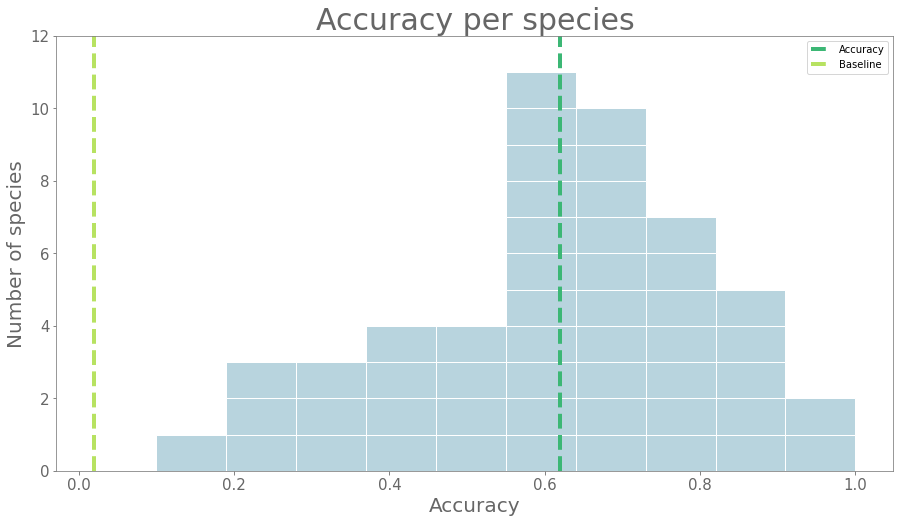

In [ ]:
plot_top1_acc(y_pred, ylim=12)

In [209]:
df_top3_grouped = top3_acc_grouped(y_pred)
df_top3_grouped.sort_values(by='Top1Accuracy', ascending=False)

,Top1Accuracy,Top2Accuracy,Top3Accuracy
Target,,,
Troglodytes troglodytes,1.0,1.0,1.0
Phylloscopus sibilatrix,1.0,1.0,1.0
Hirundo rustica,0.9,1.0,1.0
Alauda arvensis,0.9,0.9,0.9
Oriolus oriolus,0.9,0.9,0.9
Linaria cannabina,0.9,0.9,0.9
Cuculus canorus,0.9,0.9,0.9
Phylloscopus collybita,0.8,0.9,0.9
Acrocephalus dumetorum,0.8,0.8,0.8
